In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
import scipy.stats as stats

In [2]:
# parse xml file for IMU data
tree = ET.parse('climb-down.xml') # 100Hz sampling
root = tree.getroot()
value_list = []
# TODO: check that all values begin with 0x55 prefix
for item in root.iter('assert-value'):
    value_list.append(item.get('value'))


In [4]:
# test code
def twos_complement(hexstr, bits):
    value = int(hexstr, 16)
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value
test_value = "55A1CF0CFF80004A012406F3EBA32628"
# default config is ± 4g for the accelerometer and ± 500deg/s for the gyroscope
# https://www.esense.io/share/eSense-BLE-Specification.pdf
# check scale factor LSB??
acc_scale = 8192
gyro_scale = 65.5
fs = 100

In [75]:
x_gyro = [twos_complement(i[8:12], 16)/gyro_scale for i in value_list]
y_gyro = [twos_complement(i[12:16], 16)/gyro_scale for i in value_list]
z_gyro = [twos_complement(i[16:20], 16)/gyro_scale for i in value_list]
t = np.linspace(0, len(x_gyro)/fs, len(x_gyro))
plt.figure(figsize=(15, 17))
ax = plt.subplot(2, 1, 1)
plt.plot(t, x_gyro)
plt.plot(t, y_gyro)
plt.plot(t, z_gyro)
ax.set_xlabel("seconds")
ax.set_ylabel("deg/s")
plt.title("gyro - climbing up stairs fs=100Hz")


Text(0.5, 1.0, 'gyro - climbing up stairs fs=100Hz')

Text(0.5, 1.0, 'acc - walking at fs=100Hz')

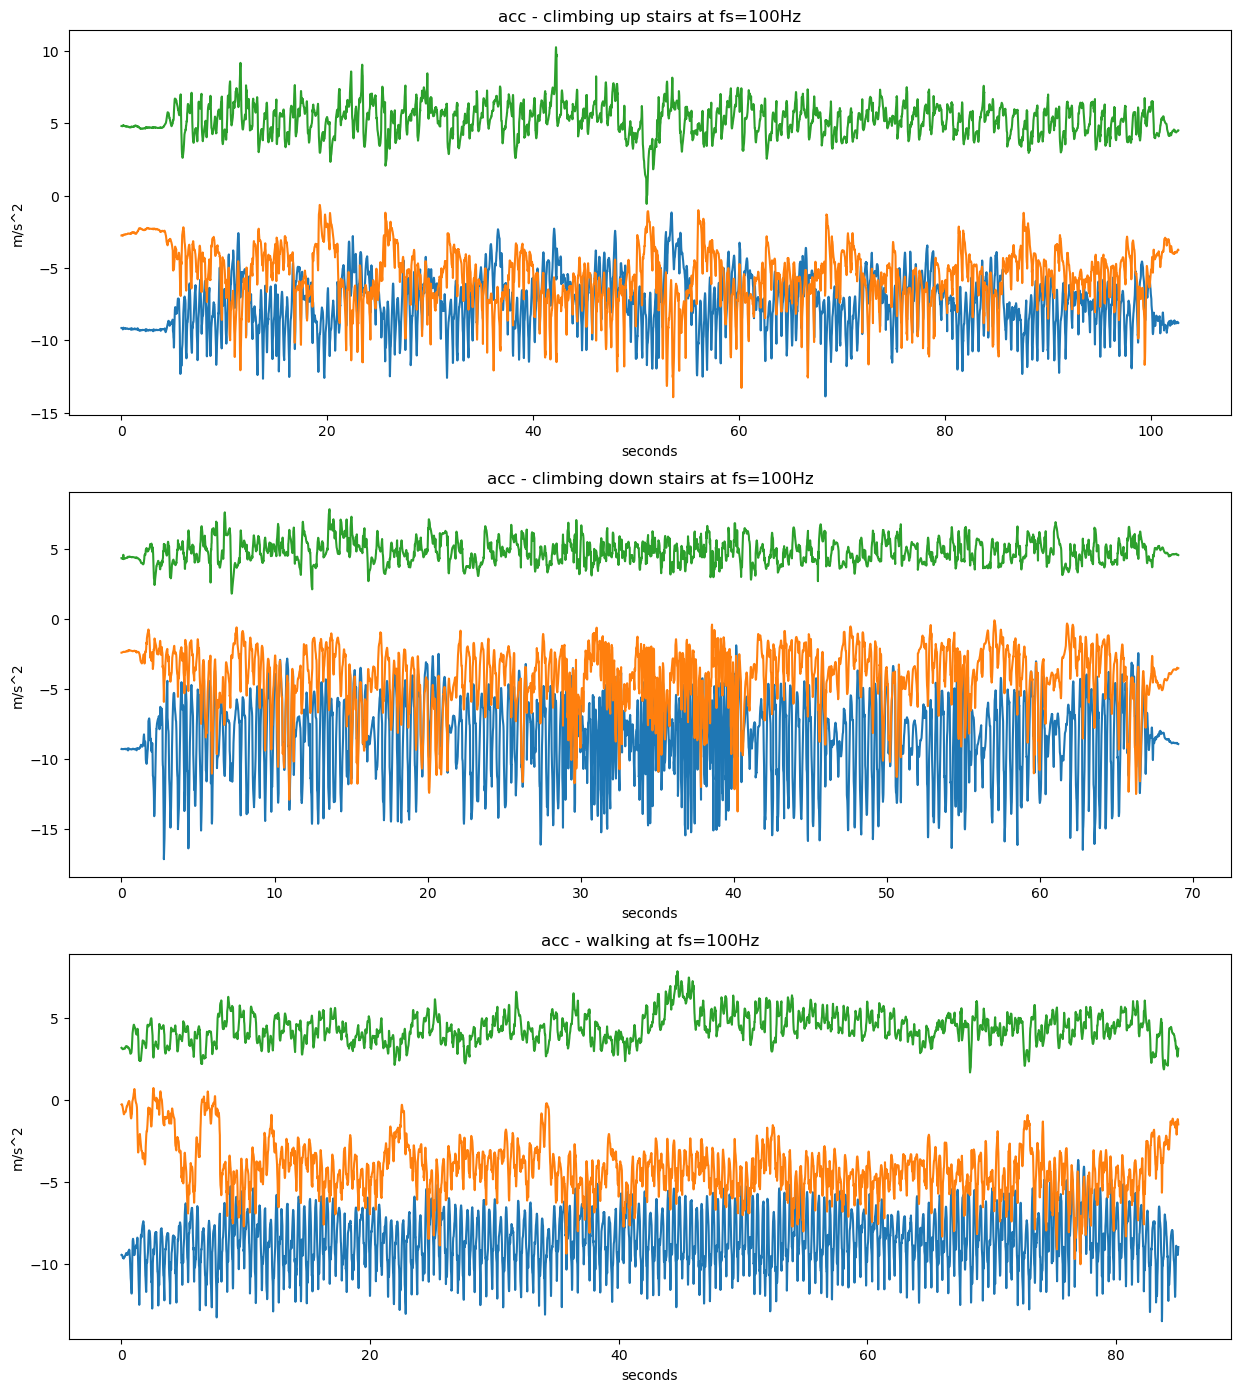

In [11]:
tree = ET.parse('climb-up.xml') # 100Hz sampling
root = tree.getroot()
value_list = []
# TODO: check that all values begin with 0x55 prefix
for item in root.iter('assert-value'):
    value_list.append(item.get('value'))
x_acc = [(twos_complement(i[20:24], 16)/acc_scale)*9.80665 for i in value_list]
y_acc = [(twos_complement(i[24:28], 16)/acc_scale)*9.80665 for i in value_list]
z_acc = [(twos_complement(i[28:32], 16)/acc_scale)*9.80665 for i in value_list]
t = np.linspace(0, len(x_acc)/fs, len(x_acc))

fig = plt.figure(figsize=(15, 17))
#ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(t, x_acc, label='x')
ax1.plot(t, y_acc, label='y')
ax1.plot(t, z_acc, label='z')
ax1.set_title("acc - climbing up stairs at fs=100Hz")
ax1.set_xlabel("seconds")
ax1.set_ylabel("m/s^2")

tree = ET.parse('climb-down.xml') # 100Hz sampling
root = tree.getroot()
value_list = []
# TODO: check that all values begin with 0x55 prefix
for item in root.iter('assert-value'):
    value_list.append(item.get('value'))
x_acc = [(twos_complement(i[20:24], 16)/acc_scale)*9.80665 for i in value_list]
y_acc = [(twos_complement(i[24:28], 16)/acc_scale)*9.80665 for i in value_list]
z_acc = [(twos_complement(i[28:32], 16)/acc_scale)*9.80665 for i in value_list]
t = np.linspace(0, len(x_acc)/fs, len(x_acc))
#plt.subplot(3,1,2)
ax2.plot(t, x_acc, label='x')
ax2.plot(t, y_acc, label='y')
ax2.plot(t, z_acc, label='z')
ax2.set_title("acc - climbing down stairs at fs=100Hz")
ax2.set_xlabel("seconds")
ax2.set_ylabel("m/s^2")

tree = ET.parse('walking.xml') # 100Hz sampling
root = tree.getroot()
value_list = []
# TODO: check that all values begin with 0x55 prefix
for item in root.iter('assert-value'):
    value_list.append(item.get('value'))
x_acc = [(twos_complement(i[20:24], 16)/acc_scale)*9.80665 for i in value_list]
y_acc = [(twos_complement(i[24:28], 16)/acc_scale)*9.80665 for i in value_list]
z_acc = [(twos_complement(i[28:32], 16)/acc_scale)*9.80665 for i in value_list]
t = np.linspace(0, len(x_acc)/fs, len(x_acc))
plt.subplot(3,1,3)
ax3.plot(t, x_acc, label='x')
ax3.plot(t, y_acc, label='')
ax3.plot(t, z_acc, label='z')
ax3.set_xlabel("seconds")
ax3.set_ylabel("m/s^2")
ax3.set_title("acc - walking at fs=100Hz")

In [ ]:
# parse xml file for IMU data
files = ['walking.xml', 'climb-down.xml', 'climb-up.xml']
imu_list = []
label_list = []
for i in files:
    tree = ET.parse(i) # 100Hz sampling
    root = tree.getroot()
    # TODO: check that all values begin with 0x55 prefix
    for item in root.iter('assert-value'):
        imu_list.append(item.get('value'))
        label_list.append(i.split('.')[0])

In [32]:
label = LabelEncoder()
label_list_encoded=label.fit_transform(label_list)

# convert hex value to decimal number
def twos_complement(hexstr, bits): 
    value = int(hexstr, 16)
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

acc_scale = 8192
gyro_scale = 65.5
fs = 100

In [33]:
# data preprocessing
# normalize each channel of accelerometer to zero mean and standard deviation of one by subtracting mean and dividing by standard deviation
x_acc = [(twos_complement(i[20:24], 16)/acc_scale)*9.80665 for i in imu_list]
y_acc = [(twos_complement(i[24:28], 16)/acc_scale)*9.80665 for i in imu_list]
z_acc = [(twos_complement(i[28:32], 16)/acc_scale)*9.80665 for i in imu_list]

x_mean = np.mean(x_acc)
x_std = np.std(x_acc)
y_mean = np.mean(y_acc)
y_std = np.std(y_acc)
z_mean = np.mean(z_acc)
z_std = np.std(z_acc)

x_acc_normalized = (x_acc - x_mean)/x_std
y_acc_normalized = (y_acc - y_mean)/y_std
z_acc_normalized = (z_acc - z_mean)/z_std

In [ ]:
# segment data into windows of length 512 with 256 samples overlapping between consecutive windows
x_list = [] # 350 x 512 (350 windows, each window of length 512)
y_list = []
z_list = []
labels = []
frame_size = 512
hop_size = 256
for i in range(0, len(imu_list) - frame_size, hop_size):

    x = x_acc_normalized[i: i + frame_size]
    y = y_acc_normalized[i: i + frame_size]
    z = z_acc_normalized[i: i + frame_size]
    
    # Use most often used label in this segment as the label for the overall frame
    label = stats.mode(label_list_encoded[i: i + frame_size])[0][0]
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    labels.append(label)

# extract mean, std, fft energy and correlation of each window
# selected these features due to this paper https://www.aaai.org/Papers/IAAI/2005/IAAI05-013.pdf
X = pd.DataFrame()
y = labels
# mean of each window
X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean()) 
X['y_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X['z_mean'] = pd.Series(x_list).apply(lambda x: x.mean())

# standard deviation
X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# FFT energy
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])

X['x_fft_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))
X['y_fft_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))
X['z_fft_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))

# correlation
corr_xy_list = []
corr_yz_list = []
corr_xz_list = []
for i in range(0, len(x_list)):
    corr_xy, _ = pearsonr(x_list[i], y_list[i])
    corr_yz, _ = pearsonr(y_list[i], z_list[i])
    corr_xz, _ = pearsonr(x_list[i], z_list[i])

    corr_xy_list.append(corr_xy)
    corr_yz_list.append(corr_yz)
    corr_xz_list.append(corr_xz)
X['xy_corr'] = corr_xy_list
X['yz_corr'] = corr_yz_list
X['xz_corr'] = corr_xz_list

# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)


In [68]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# determine precision, recall, and f1 scores from 10-fold cross validation
precision = cross_val_score(rf, X, y, cv=10, scoring='precision_macro')
recall = cross_val_score(rf, X, y, cv=10, scoring='recall_macro')
f1_scores = cross_val_score(rf, X, y, cv=10, scoring='f1_macro')
print("k-Nearest neighbors classifier over 10-fold cross validation: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

k-Nearest neighbors classifier over 10-fold cross validation: 
mean precision: 0.9155555555555555 mean recall: 0.9361111111111111 mean F1 score: 0.9092328042328044 


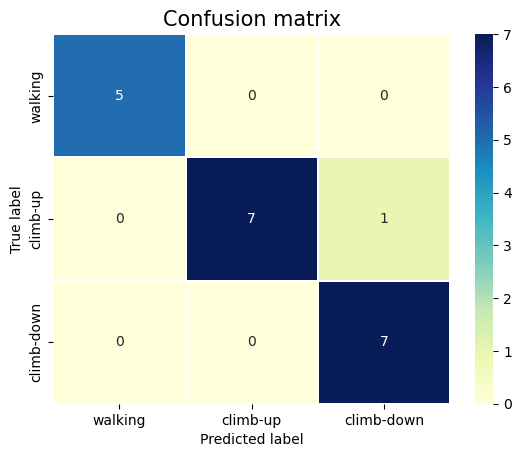

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels = ['walking', 'climb-up', 'climb-down']
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()